In [2]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torchvision.io import read_image
from torch.utils.data import DataLoader,Dataset, ConcatDataset
import matplotlib.pyplot as plt
from scripts.custom_Dataset import CustomDataset


In [3]:


def show_images_grid(dataloader1, dataloader2, dataloader3, classes, model, invTrans, num_images=10):
    dataloaders = [dataloader1, dataloader2, dataloader3]
    fig, axs = plt.subplots(num_images, 3, figsize=(10, 30))

    for i, dataloader in enumerate(dataloaders):
        # Get a batch of data
        it = iter(dataloader)
        data = it.next()
        # If this is the first dataloader, it also has captions
        if i == 1:
            images, labels, captions = data
        else:
            images, labels = data
            captions = [None] * len(images)
        if i!=0:
            labels = model(images)
            _, labels = torch.max(labels, dim=1)

        # Iterate over the first 'num_images' images from this dataloader
        for img_idx, (img, label, caption) in enumerate(zip(images, labels, captions)):
            if img_idx >= num_images:
                break
            img = invTrans(img)
            # Denormalize the images if needed
            # img = img / 2 + 0.5

            # Transform image for display, permute is used to re-order the dimensions from CxHxW to HxWxC
            img = img.permute(1, 2, 0)
            axs[img_idx, i].imshow(img)
            
            # Set title to include caption if present
            if i==0:
                title = f'Label: {classes[label.item()]}'
            if i==1:
                title = f'Label: {classes[label.item()]}'
                title += f', Caption: {caption}'
            else:
                title = f'Label: {classes[label.item()]}'
            
            axs[img_idx, i].set_title(title)
            axs[img_idx, i].axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((96,96)),
                      normalize])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
batch_size = 16
num_classes = 10

In [5]:
adv_image_folder = '../BLIP/experiment_1/stl_10/adv_test_diffusion_trained_AA/'
clean_image_folder = '../BLIP/experiment_1/stl_10/clean_test_images/'
generated_image_folder = '../BLIP/experiment_1/stl_10/adv_test_generated_diffusion_trained_AA/resized/'
label_file = '../BLIP/experiment_1/stl_10/clean_test_labels.txt'
caption_file = '../BLIP/experiment_1/stl_10/adv_test_diffusion_trained_AA_captions.txt'
adv_test_dataset = CustomDataset(adv_image_folder, label_file, caption_file, transform=transform)
adv_test_loader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=batch_size,
                                     shuffle=False)

clean_test_dataset = CustomDataset(clean_image_folder, label_file, transform=transform)
clean_test_loader = torch.utils.data.DataLoader(clean_test_dataset, batch_size=batch_size,
                                     shuffle=False)

generated_test_dataset = CustomDataset(generated_image_folder, label_file, transform=transform)
generated_test_loader = torch.utils.data.DataLoader(generated_test_dataset, batch_size=batch_size,
                                     shuffle=False)

classes = ['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

In [6]:
model = torch.load("resnet50_stl10_trained_on_diffusion_images.pth")
model = model.cpu()
model = model.eval()

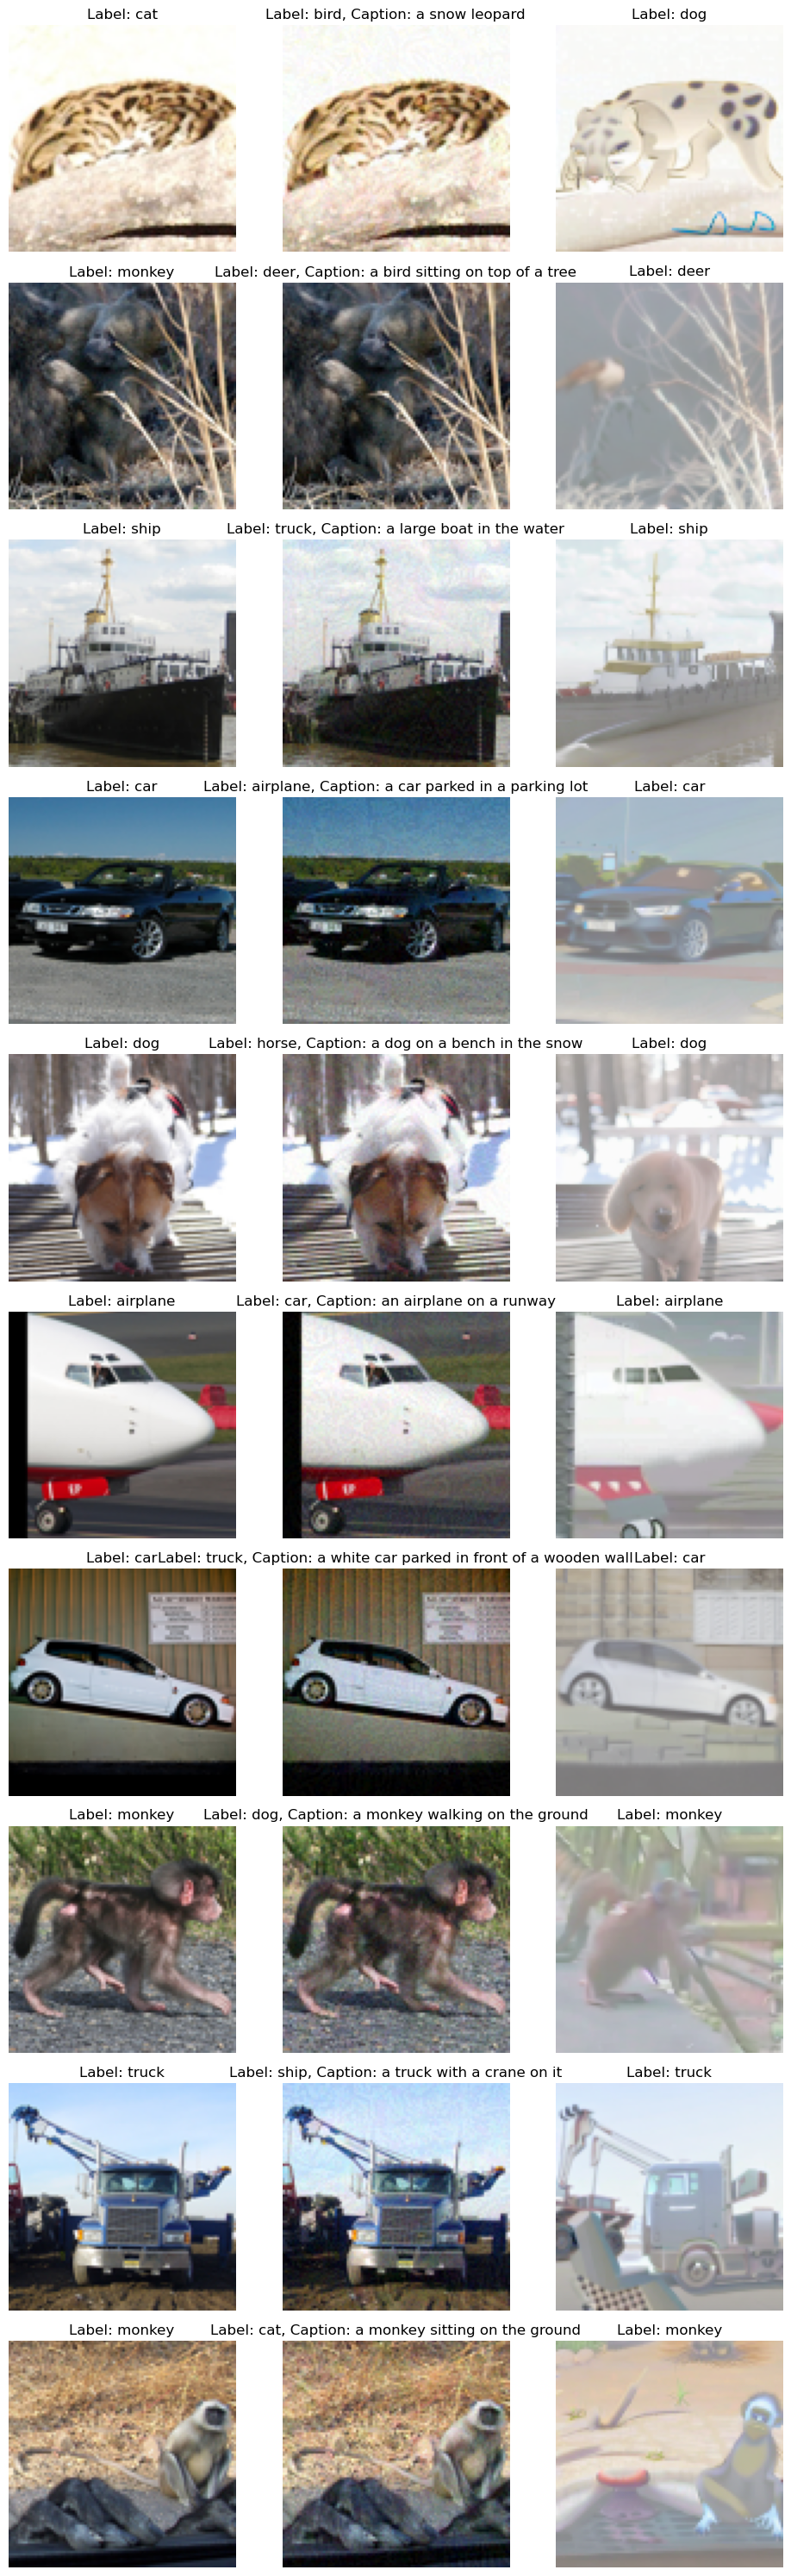

In [7]:

# Call the function
show_images_grid(clean_test_loader, adv_test_loader, generated_test_loader, classes, model, invTrans)